In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the dataset
df = pd.read_csv('churn.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Sex,Age,CurrentWorkingStatus,Tenure,Balance,NumOfProducts,ComplaintsLodged,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,France,Female,1.0,42.0,1.0,2.0,0.00,1.0,1.0,1.0,1.0,101348.88,Yes
1,2,15647311,Hill,608.0,Spain,Female,1.0,41.0,1.0,1.0,83807.86,1.0,0.0,0.0,1.0,112542.58,No
2,3,15619304,Onio,502.0,France,Female,1.0,42.0,1.0,8.0,159660.80,3.0,1.0,1.0,0.0,113931.57,Yes
3,4,15701354,Boni,699.0,France,Female,1.0,39.0,1.0,1.0,0.00,2.0,0.0,0.0,0.0,?,No
4,5,15737888,Mitchell,850.0,Spain,Female,1.0,43.0,1.0,2.0,125510.82,1.0,0.0,1.0,1.0,79084.1,No


In [3]:
# Get basic information
print("\nDataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

# Summary statistics
print("\nSummary statistics:")
df.describe()


Dataset shape: (10000, 17)

Data types:
RowNumber                 int64
CustomerId                int64
Surname                  object
CreditScore             float64
Geography                object
Gender                   object
Sex                     float64
Age                     float64
CurrentWorkingStatus    float64
Tenure                  float64
Balance                 float64
NumOfProducts           float64
ComplaintsLodged        float64
HasCrCard               float64
IsActiveMember          float64
EstimatedSalary          object
Exited                   object
dtype: object

Summary statistics:


,RowNumber,CustomerId,CreditScore,Sex,Age,CurrentWorkingStatus,Tenure,Balance,NumOfProducts,ComplaintsLodged,HasCrCard,IsActiveMember
count,10000.00000,1.000000e+04,9963.000000,9805.000000,9963.000000,9963.000000,9963.000000,9963.000000,9859.000000,9963.000000,9963.000000,9963.000000
mean,5000.50000,1.569094e+07,650.624812,0.453952,38.898223,0.996587,5.014453,76501.435194,1.531088,0.207167,0.705510,0.515006
std,2886.89568,7.193619e+04,96.606044,0.497900,10.541477,0.058321,2.891880,62411.069692,0.582007,0.405296,0.455836,0.499800
min,1.00000,1.556570e+07,350.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2500.75000,1.562853e+07,584.000000,0.000000,32.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,5000.50000,1.569074e+07,652.000000,0.000000,37.000000,1.000000,5.000000,97234.580000,1.000000,0.000000,1.000000,1.000000
75%,7500.25000,1.575323e+07,718.000000,1.000000,44.000000,1.000000,7.500000,127657.840000,2.000000,0.000000,1.000000,1.000000
max,10000.00000,1.581569e+07,850.000000,1.000000,92.000000,1.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,1.000000


In [4]:
# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Alternative check for missing or problematic values
print("\nChecking for '?' values or other potential issues:")
for column in df.columns:
    if df[column].dtype == 'object':
        unique_values = df[column].unique()
        if '?' in unique_values:
            print(f"Column '{column}' contains '?' values: {df[column].value_counts()['?']} occurrences")


Missing values per column:
Surname                  86
CreditScore              37
Geography                37
Gender                   37
Sex                     195
Age                      37
CurrentWorkingStatus     37
Tenure                   37
Balance                  37
NumOfProducts           141
ComplaintsLodged         37
HasCrCard                37
IsActiveMember           37
EstimatedSalary         104
dtype: int64

Checking for '?' values or other potential issues:
Column 'EstimatedSalary' contains '?' values: 64 occurrences


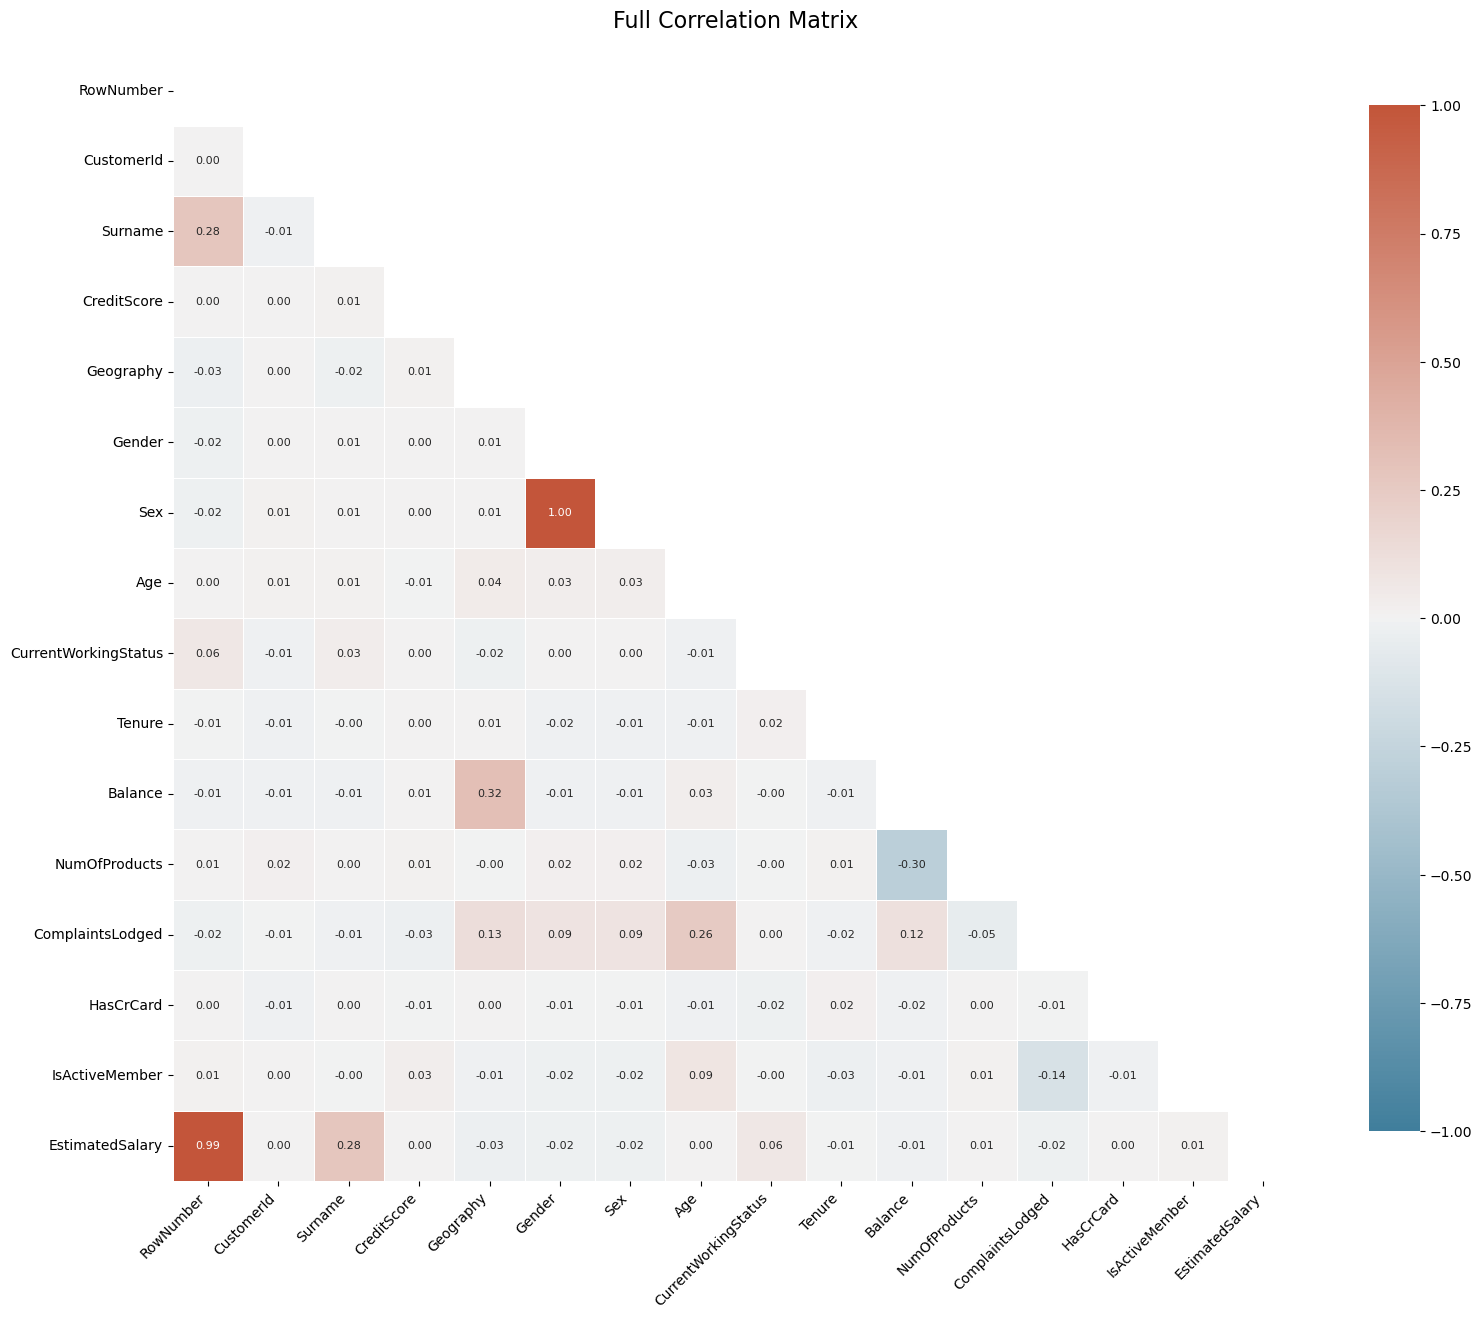

Correlation between Gender and Sex: 1.0000
Very strong correlation confirms these variables contain the same information.


In [5]:
# Generate full correlation matrix to show all variable relationships
# Convert categorical variables to numeric for correlation calculation
df_corr = df.copy()
# For correlation calculation, convert categorical variables to numeric
if 'Gender' in df_corr.columns:
    # Map Gender to numeric (only if it's not already numeric)
    if df_corr['Gender'].dtype == 'object':
        df_corr['Gender'] = df_corr['Gender'].map({'Male': 0, 'Female': 1})
# Handle any other string columns or non-numeric data
for col in df_corr.columns:
    if df_corr[col].dtype == 'object' and col != 'Exited':
        df_corr[col] = pd.factorize(df_corr[col])[0]

# Replace any remaining non-numeric values (like '?') with NaN
df_corr = df_corr.apply(pd.to_numeric, errors='coerce')

# Drop target variable from correlation analysis
df_corr = df_corr.drop(columns=['Exited'])

# Calculate full correlation matrix
full_correlation = df_corr.corr()
# Visualize the full correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(full_correlation, dtype=bool))  # Create mask for upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Define colormap
# Plot heatmap with better readability
sns.heatmap(full_correlation, 
            mask=mask,  # Mask upper triangle
            cmap=cmap,
            vmax=1.0, vmin=-1.0,  # Set limits
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .8},
            annot=True,  # Show correlation values
            fmt='.2f',  # Format to 2 decimal places
            annot_kws={"size": 8})  # Adjust annotation size
plt.title('Full Correlation Matrix', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('full_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
# Also output the correlation between Gender and Sex specifically
if 'Gender' in df_corr.columns and 'Sex' in df_corr.columns:
    gender_sex_corr = full_correlation.loc['Gender', 'Sex']
    print(f"Correlation between Gender and Sex: {gender_sex_corr:.4f}")
    if abs(gender_sex_corr) > 0.95:
        print("Very strong correlation confirms these variables contain the same information.")

In [11]:
# 1. Remove unnecessary variables
print("Step 1: Removing unnecessary variables")

# Create a clean copy of the dataframe
df_clean = df.copy()

# Remove irrelevant columns
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df_clean = df_clean.drop(columns=columns_to_drop)
print(f"Dropped irrelevant columns: {columns_to_drop}")

# Display the dataset shape after removing columns
print(f"Dataset shape after removing unnecessary columns: {df_clean.shape}")
print(f"Remaining columns: {df_clean.columns.tolist()}")

Step 1: Removing unnecessary variables
Dropped irrelevant columns: ['RowNumber', 'CustomerId', 'Surname']
Dataset shape after removing unnecessary columns: (10000, 14)
Remaining columns: ['CreditScore', 'Geography', 'Gender', 'Sex', 'Age', 'CurrentWorkingStatus', 'Tenure', 'Balance', 'NumOfProducts', 'ComplaintsLodged', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [13]:
# 2. Standardize values and fix structural issues
print("Step 2: Standardizing values and fixing structural issues")

# Map Geography variants to standard country names
geography_mapping = {
    'DE': 'Germany',
    'ES': 'Spain',
    'FR': 'France'
}

df_clean['Geography'] = df_clean['Geography'].replace(geography_mapping)
print(f"Mapped Geography variants to standard names: {geography_mapping}")

# Check the unique values in Geography after standardization
print(f"Unique Geography values after standardization: {df_clean['Geography'].unique()}")

# Check correlation between Gender and Sex
gender_sex_crosstab = pd.crosstab(df_clean['Gender'], df_clean['Sex'])
print("\nCross-tabulation of Gender and Sex:")
print(gender_sex_crosstab)

# Since they're highly correlated, we can drop one (keeping Sex as it's already numeric)
df_clean = df_clean.drop(columns=['Gender'])
print("Dropped Gender column as it's highly correlated with Sex (Sex is kept as it's already numeric)")

Step 2: Standardizing values and fixing structural issues
Mapped Geography variants to standard names: {'DE': 'Germany', 'ES': 'Spain', 'FR': 'France'}
Unique Geography values after standardization: ['France' 'Spain' 'Germany' nan]

Cross-tabulation of Gender and Sex:
Sex      0.0   1.0
Gender            
Female     0  4451
Male    5354     0
Dropped Gender column as it's highly correlated with Sex (Sex is kept as it's already numeric)


In [15]:
# 3. Handle missing values
print("Step 3: Handling missing values")
# Check for missing values in each column
missing_values = df_clean.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])
# Handle missing values in numerical columns
num_cols = ['CreditScore', 'Sex', 'Age', 'CurrentWorkingStatus', 'Tenure', 
            'Balance', 'NumOfProducts', 'ComplaintsLodged', 'HasCrCard', 'IsActiveMember']
for col in num_cols:
    missing_count = df_clean[col].isnull().sum()
    if missing_count > 0:
        # Fill missing values with median
        median_value = df_clean[col].median()
        df_clean[col].fillna(median_value, inplace=True)
        print(f"Filled {missing_count} missing values in {col} with median: {median_value}")
# Handle missing values in Geography
missing_geo = df_clean['Geography'].isnull().sum()
if missing_geo > 0:
    # Fill missing Geography with the mode (most common value)
    mode_geo = df_clean['Geography'].mode()[0]
    df_clean['Geography'].fillna(mode_geo, inplace=True)
    print(f"Filled {missing_geo} missing values in Geography with mode: {mode_geo}")
# Handle EstimatedSalary - convert to numeric and handle missing/? values
df_clean['EstimatedSalary'] = df_clean['EstimatedSalary'].replace('?', np.nan)
df_clean['EstimatedSalary'] = pd.to_numeric(df_clean['EstimatedSalary'], errors='coerce')
missing_salary = df_clean['EstimatedSalary'].isnull().sum()
if missing_salary > 0:
    median_salary = df_clean['EstimatedSalary'].median()
    df_clean['EstimatedSalary'].fillna(median_salary, inplace=True)
    print(f"Converted EstimatedSalary to numeric and filled {missing_salary} missing values with median: {median_salary}")
# Handle missing values in target variable
missing_target = df_clean['Exited'].isnull().sum()
if missing_target > 0:
    mode_target = df_clean['Exited'].mode()[0]
    df_clean['Exited'].fillna(mode_target, inplace=True)
    print(f"Filled {missing_target} missing values in Exited with mode: {mode_target}")
# Verify no missing values remain
missing_after = df_clean.isnull().sum().sum()
print(f"\nMissing values after cleaning: {missing_after}")

Step 3: Handling missing values
Missing values per column:
CreditScore              37
Geography                37
Sex                     195
Age                      37
CurrentWorkingStatus     37
Tenure                   37
Balance                  37
NumOfProducts           141
ComplaintsLodged         37
HasCrCard                37
IsActiveMember           37
EstimatedSalary         104
dtype: int64
Filled 37 missing values in CreditScore with median: 652.0
Filled 195 missing values in Sex with median: 0.0
Filled 37 missing values in Age with median: 37.0
Filled 37 missing values in CurrentWorkingStatus with median: 1.0
Filled 37 missing values in Tenure with median: 5.0
Filled 37 missing values in Balance with median: 97234.58
Filled 141 missing values in NumOfProducts with median: 1.0
Filled 37 missing values in ComplaintsLodged with median: 0.0
Filled 37 missing values in HasCrCard with median: 1.0
Filled 37 missing values in IsActiveMember with median: 1.0
Filled 37 missing va

In [17]:
# 4. Fix data quality issues
print("Step 4: Fixing data quality issues")

# Check and fix negative Age values
negative_ages = (df_clean['Age'] < 0).sum()
if negative_ages > 0:
    print(f"Found {negative_ages} negative Age values")
    # Replace negative ages with median age
    median_age = df_clean.loc[df_clean['Age'] >= 0, 'Age'].median()
    df_clean.loc[df_clean['Age'] < 0, 'Age'] = median_age
    print(f"Replaced negative Age values with median: {median_age}")
else:
    print("No negative Age values found")

# Check for extreme/outlier values in key numerical columns
print("\nChecking for extreme values in numerical columns:")

# Function to detect and handle outliers
def check_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers_count = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    outliers_percent = outliers_count / df.shape[0] * 100
    
    print(f"{column}: {outliers_count} outliers ({outliers_percent:.2f}%)")
    
    # For information only, we're not automatically handling all outliers
    return outliers_count

# Check for outliers in key columns
check_outliers(df_clean, 'CreditScore')
check_outliers(df_clean, 'Age')
check_outliers(df_clean, 'Balance')
check_outliers(df_clean, 'NumOfProducts')
check_outliers(df_clean, 'EstimatedSalary')

# Convert target variable to numeric for modeling
print("\nConverting target variable to numeric")
df_clean['Exited'] = df_clean['Exited'].map({'No': 0, 'Yes': 1})
print("Mapped Exited values: No=0, Yes=1")

# Display the final processed dataset information
print("\nFinal dataset information:")
print(f"Shape: {df_clean.shape}")
print("Column data types:")
print(df_clean.dtypes)

# Look at first few rows of cleaned data
print("\nFirst 5 rows of cleaned data:")
df_clean.head()

Step 4: Fixing data quality issues
Found 6 negative Age values
Replaced negative Age values with median: 37.0

Checking for extreme values in numerical columns:
CreditScore: 16 outliers (0.16%)
Age: 359 outliers (3.59%)
Balance: 0 outliers (0.00%)
NumOfProducts: 60 outliers (0.60%)
EstimatedSalary: 0 outliers (0.00%)

Converting target variable to numeric
Mapped Exited values: No=0, Yes=1

Final dataset information:
Shape: (10000, 13)
Column data types:
CreditScore             float64
Geography                object
Sex                     float64
Age                     float64
CurrentWorkingStatus    float64
Tenure                  float64
Balance                 float64
NumOfProducts           float64
ComplaintsLodged        float64
HasCrCard               float64
IsActiveMember          float64
EstimatedSalary         float64
Exited                    int64
dtype: object

First 5 rows of cleaned data:


,CreditScore,Geography,Sex,Age,CurrentWorkingStatus,Tenure,Balance,NumOfProducts,ComplaintsLodged,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,1.0,42.0,1.0,2.0,0.00,1.0,1.0,1.0,1.0,101348.880,1
1,608.0,Spain,1.0,41.0,1.0,1.0,83807.86,1.0,0.0,0.0,1.0,112542.580,0
2,502.0,France,1.0,42.0,1.0,8.0,159660.80,3.0,1.0,1.0,0.0,113931.570,1
3,699.0,France,1.0,39.0,1.0,1.0,0.00,2.0,0.0,0.0,0.0,100438.025,0
4,850.0,Spain,1.0,43.0,1.0,2.0,125510.82,1.0,0.0,1.0,1.0,79084.100,0


In [19]:
# 5. Feature Encoding
print("Step 5: Feature Encoding")

# One-hot encode the Geography column
print("One-hot encoding Geography column")
geography_dummies = pd.get_dummies(df_clean['Geography'], prefix='Geography', drop_first=False)

# Add the encoded columns to the dataframe
df_clean = pd.concat([df_clean.drop(columns=['Geography']), geography_dummies], axis=1)

print(f"Added {geography_dummies.shape[1]} new columns for Geography")
print(f"Final dataset shape: {df_clean.shape}")

# Check the first few rows to verify encoding
print("\nFirst 5 rows with encoded Geography:")
df_clean.head()

Step 5: Feature Encoding
One-hot encoding Geography column
Added 3 new columns for Geography
Final dataset shape: (10000, 15)

First 5 rows with encoded Geography:


,CreditScore,Sex,Age,CurrentWorkingStatus,Tenure,Balance,NumOfProducts,ComplaintsLodged,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619.0,1.0,42.0,1.0,2.0,0.00,1.0,1.0,1.0,1.0,101348.880,1,True,False,False
1,608.0,1.0,41.0,1.0,1.0,83807.86,1.0,0.0,0.0,1.0,112542.580,0,False,False,True
2,502.0,1.0,42.0,1.0,8.0,159660.80,3.0,1.0,1.0,0.0,113931.570,1,True,False,False
3,699.0,1.0,39.0,1.0,1.0,0.00,2.0,0.0,0.0,0.0,100438.025,0,True,False,False
4,850.0,1.0,43.0,1.0,2.0,125510.82,1.0,0.0,1.0,1.0,79084.100,0,False,False,True
